In this notebook a CNN model is trained to classify the images captured by dashboard camera into 10 different classes based on their activity while they are driving such as whether they 'driving safe','texting','drinking','reaching behind',etc.The model was able to achive 99% accuracy on both training and validation data.

In [109]:
#importing necessary modules and libraries.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from glob import glob
import cv2
import random
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import load_model

The 10 classes to predict:

- c0: safe driving 
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio
- c6: drinking
- c7: reaching behind
- c8: hair and makeup
- c9: talking to passenger

In [3]:
# defining the path and classes.
train_directory = '../input/state-farm-distracted-driver-detection/imgs/train'
test_directory = '../input/state-farm-distracted-driver-detection/imgs/test'
classes = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

In [65]:
df = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


Visualizing counts of different classes

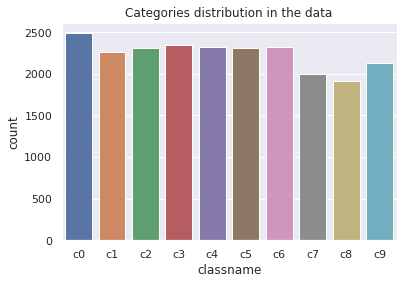

In [83]:
plt.figure()
sns.countplot(x = 'classname',data=df)
plt.title('Categories distribution in the data')
plt.show()

Visualizing an image of every class

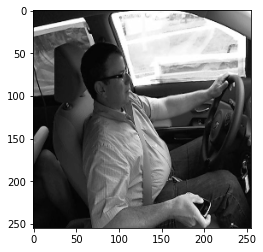

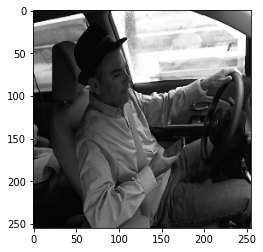

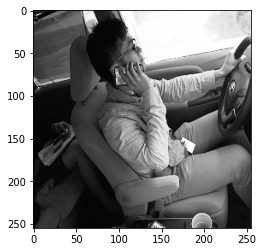

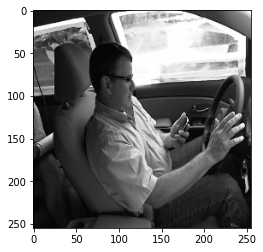

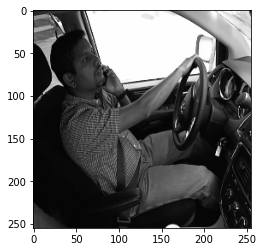

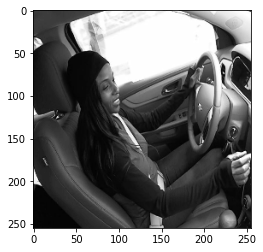

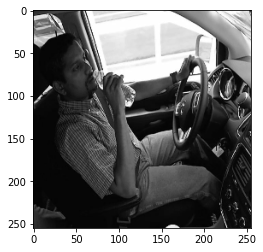

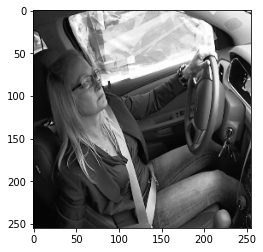

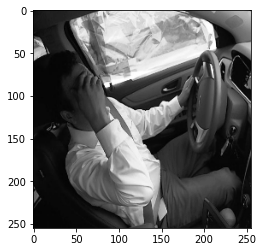

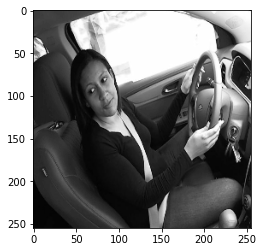

In [5]:
# Train image to display every class.
for i in range(10):
    for i in classes:
        path = os.path.join(train_directory,i)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
            img_array = cv2.resize(img_array,(255,255))
            plt.imshow(img_array, cmap='gray')
            plt.show()
            break
    break

Creating a list which consists of features of all images and their coresponding labels.

In [6]:
#creating training dataset.

training_data = []
i = 0
def create_training_data():
    for category in classes:
        path = os.path.join(train_directory,category)
        class_num = classes.index(category)
        
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
            new_img = cv2.resize(img_array,(255,255))
            training_data.append([
                new_img,class_num])

In [7]:
# Creating  test dataset.
testing_data = []
i = 0
def create_testing_data():        
    for img in os.listdir(test_directory):
        img_array = cv2.imread(os.path.join(test_directory,img),cv2.IMREAD_GRAYSCALE)
        new_img = cv2.resize(img_array,(255,255))
        testing_data.append([img,
            new_img])


In [8]:
create_training_data()

In [9]:
create_testing_data()

In [10]:
print(len(training_data))

22424


In [11]:
random.shuffle(training_data)

In [12]:
X = []
Y = []

In [13]:
for features, labels in training_data:
    X.append(features)
    Y.append(labels)

In [14]:
X = np.array(X).reshape(-1,255,255,1)
X.shape

(22424, 255, 255, 1)

Splitting data inton training and validation data.

In [15]:
X_train,x_test,Y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=50)

Converting the labels array into a one-hot vector for cnn model.

In [16]:
Y_train = np_utils.to_categorical(Y_train,num_classes=10)
y_test = np_utils.to_categorical(y_test,num_classes=10)

In [17]:
print(Y_train.shape)

(15696, 10)


Creating model.

In [19]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(255,255,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(BatchNormalization(axis = 3))
model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units = 512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units = 128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10,activation='softmax'))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 253, 253, 32)      320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 253, 253, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 251, 251, 32)      9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 251, 251, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 125, 125, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 123, 123, 64)     

In [21]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

Callbacks to avoid overfitting.

In [22]:
callbacks = [EarlyStopping(monitor='val_acc',patience=5)]

Training model.

In [23]:
hist = model.fit(X_train,Y_train,batch_size=50,epochs=30,verbose=1,validation_data=(x_test,y_test),callbacks=callbacks)

Epoch 1/30
314/314 [==============================] - 415s 1s/step - loss: 1.5443 - accuracy: 0.5204 - val_loss: 0.1729 - val_accuracy: 0.9548
Epoch 2/30
314/314 [==============================] - 394s 1s/step - loss: 0.1595 - accuracy: 0.9543 - val_loss: 0.1284 - val_accuracy: 0.9611
Epoch 3/30
314/314 [==============================] - 394s 1s/step - loss: 0.0797 - accuracy: 0.9757 - val_loss: 0.1374 - val_accuracy: 0.9603
Epoch 4/30
314/314 [==============================] - 394s 1s/step - loss: 0.0619 - accuracy: 0.9817 - val_loss: 0.1179 - val_accuracy: 0.9640
Epoch 5/30
314/314 [==============================] - 394s 1s/step - loss: 0.0456 - accuracy: 0.9853 - val_loss: 0.0550 - val_accuracy: 0.9874
Epoch 6/30
314/314 [==============================] - 394s 1s/step - loss: 0.0616 - accuracy: 0.9799 - val_loss: 0.0449 - val_accuracy: 0.9880
Epoch 7/30
314/314 [==============================] - 394s 1s/step - loss: 0.0443 - accuracy: 0.9867 - val_loss: 0.4415 - val_accuracy: 0.8814

Visualizing loss and accuracy.

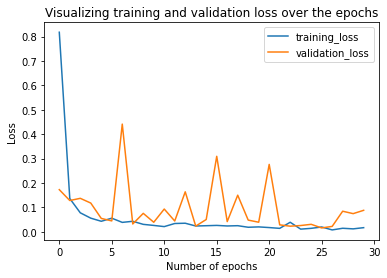

In [27]:
plt.plot(hist.history['loss'],label='training_loss')
plt.plot(hist.history['val_loss'],label='validation_loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Visualizing training and validation loss over the epochs')
plt.show()

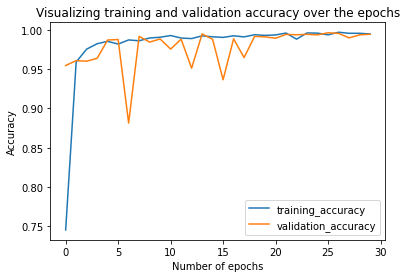

In [28]:
plt.plot(hist.history['accuracy'],label='training_accuracy')
plt.plot(hist.history['val_accuracy'],label='validation_accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Visualizing training and validation accuracy over the epochs')
plt.show()

In [29]:
model.save('./driverdistraction_modelcst.h5')


In [ ]:
loaded_model = load_model('../input/driver-distraction/driverdistraction_lr_weights.h5')

In [93]:
prd = model.predict(x_test)

In [104]:
y_prd = np.argmax(prd,axis=1)
len(y_prd)

6728

In [105]:
y_prd

array([3, 1, 1, ..., 9, 6, 3])

Plotting confusion matrix and calculating recall and precision

Results on validation data:

Accuracy = 0.9946492271105827
Precision = 0.9946679011299983
Recall = 0.9946492271105827


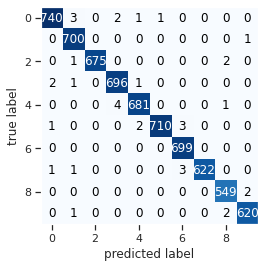

In [112]:
confusion_matrix = metrics.confusion_matrix(y_true=np.argmax(y_test,axis=1), y_pred=y_prd)
plot_confusion_matrix(confusion_matrix)
print("Results on validation data:\n")
print("Accuracy = "+str(accuracy_score(np.argmax(y_test,axis=1), y_prd)))
print("Precision = "+str(precision_score(np.argmax(y_test,axis=1),y_prd,average='weighted')))
print("Recall = "+str(recall_score(np.argmax(y_test,axis=1),y_prd,average='weighted')))

In [53]:
test_data = np.array(testing_data[1009][1]).reshape(-1,255,255,1)

In [54]:
preds = model.predict(test_data)
preds= np.argmax(preds)
preds

6

Creating a function to get the description of predicted class value.

In [60]:
def name_class(preds):    
    classes={0: 'safe driving', 
            1: 'texting - right',
            2: 'talking on the phone - right',
            3: 'texting - left',
            4: 'talking on the phone - left',
            5: 'operating the radio',
            6: 'drinking',
            7: 'reaching behind',
            8: 'hair and makeup',
            9: 'talking to passenger'}
    
    for key,value in classes.items():
        if(preds==key):
            return value
        

Predicting and visualizing some random test images to verify the performance of our model.

talking on the phone - left


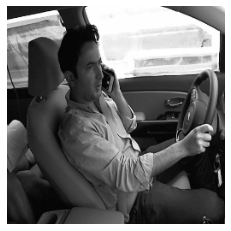

talking on the phone - left


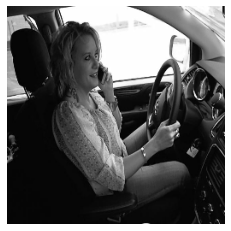

reaching behind


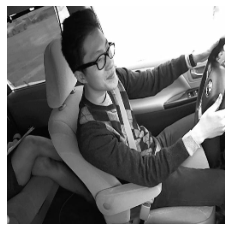

hair and makeup


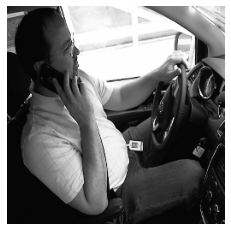

hair and makeup


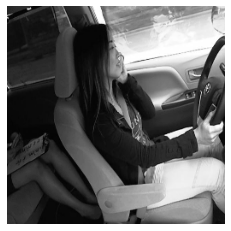

drinking


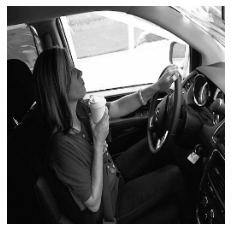

texting - left


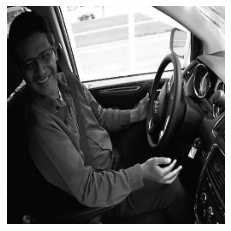

texting - right


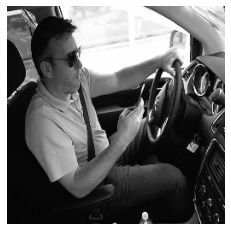

talking on the phone - right


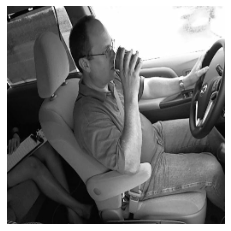

drinking


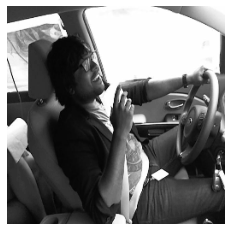

talking on the phone - left


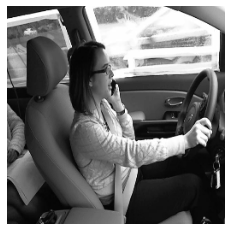

reaching behind


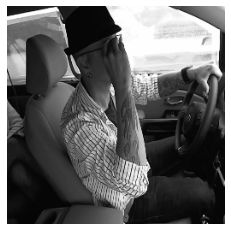

reaching behind


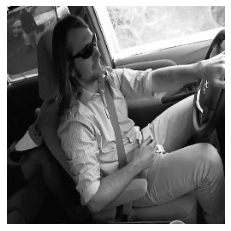

operating the radio


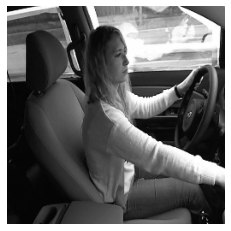

operating the radio


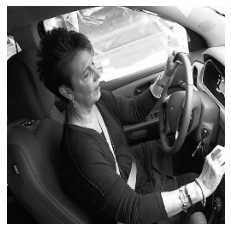

reaching behind


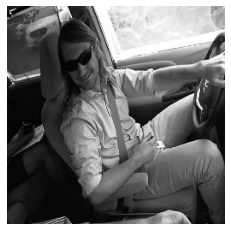

talking on the phone - right


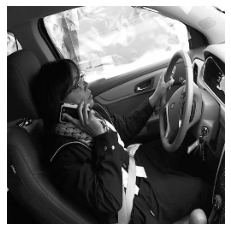

reaching behind


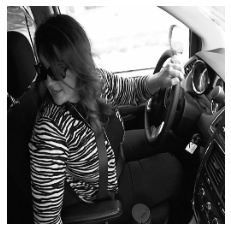

drinking


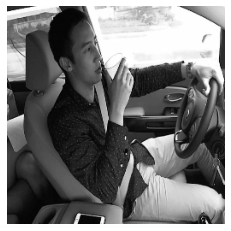

reaching behind


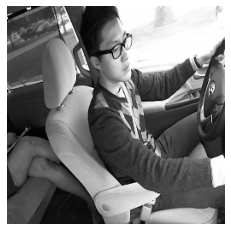

reaching behind


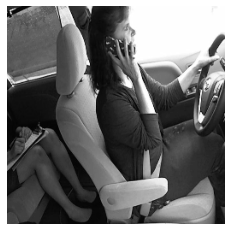

talking on the phone - right


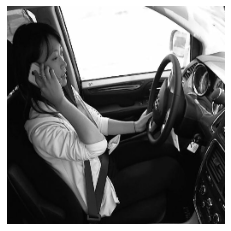

reaching behind


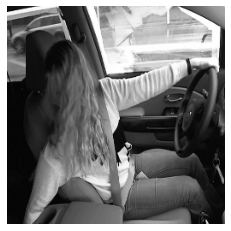

drinking


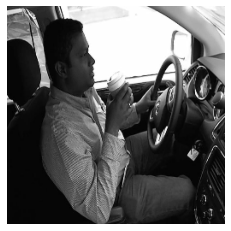

reaching behind


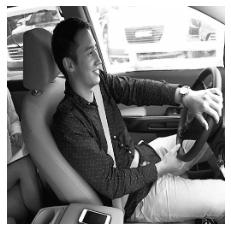

In [89]:
for i in range(1000,1025):
    test_data = np.array(testing_data[i][1]).reshape(-1,255,255,1)
    preds = model.predict(test_data)
    preds = np.argmax(preds)
    predicted = name_class(preds)
    print(predicted)
    new_img = cv2.resize(testing_data[i][1],(255,255))
    plt.imshow(new_img,cmap='gray')
    plt.axis("off")
    plt.show()

The results and the actual values are quite similar so the model have produced some good results.